In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import pickle
import random
random.seed(42)

In [2]:
num_folds = 5
base_path = '../'
input_imgs_dir = f'{base_path}/all_dataset_files/all_dataset_imgs'
input_masks_dir = f'{base_path}/all_dataset_files/all_dataset_masks'
input_annots_dir = f'{base_path}/all_dataset_files/all_dataset_annotations'
vis_output_imgs_dir = f'{base_path}/dataset1_files/all_dataset1_vis'

if not os.path.exists(vis_output_imgs_dir):
  os.mkdir(vis_output_imgs_dir)

modes = ['train', 'validation', 'validation_custom']

for i in range(num_folds):
  for mode in modes:
    output_imgs_dir_fold = f'{base_path}/dataset1_files/all_dataset1_{mode}_imgs_context_fold_{i}' if mode != 'validation_custom' else f'{base_path}/dataset1_files/all_dataset1_validation_imgs_context_fold_{i}'
    output_annots_dir_fold = f'{base_path}/dataset1_files/all_dataset1_{mode}_annotations_context_fold_{i}'
    if not os.path.exists(output_imgs_dir_fold):
      os.mkdir(output_imgs_dir_fold)
    if not os.path.exists(output_annots_dir_fold):
      os.mkdir(output_annots_dir_fold)

In [3]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info
def calculate_area(coordinates):
    num_points = len(coordinates)
    if num_points < 3:
        return 0

    area = 0
    for i in range(num_points - 1):
        x_i, y_i = coordinates[i]
        x_iplus1, y_iplus1 = coordinates[i + 1]
        area += (x_i * y_iplus1) - (x_iplus1 * y_i)

    x_n, y_n = coordinates[-1]
    x_0, y_0 = coordinates[0]
    area += (x_n * y_0) - (x_0 * y_n)

    area = abs(area / 2)
    return area
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(30, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
with open(f'{base_path}/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [5]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
tile_df_annotated.head()

,id,source_wsi,dataset,i,j,blood_vessel,glomerulus,unsure
0,0006ff2aa7cd,2,2,16896,16420,8,1,0
1,00168d1b7522,2,2,14848,14884,1,1,0
2,0033bbc76b6b,1,1,10240,43008,3,0,1
3,003504460b3a,3,2,8192,11776,7,0,0
4,004daf1cbe75,3,2,6144,11264,10,1,0


In [6]:
dataset_1 = tile_df_annotated.loc[tile_df_annotated['dataset']==1]
dataset_1_tile_ids = sorted(dataset_1.loc[:, 'id'].values)
dataset_1_wsi_1_pos_dict = {(x[0], x[1]): x[-1] for x in dataset_1.loc[dataset_1['source_wsi']==1, ['i', 'j', 'id']].values}
dataset_1_wsi_2_pos_dict = {(x[0], x[1]): x[-1] for x in dataset_1.loc[dataset_1['source_wsi']==2, ['i', 'j', 'id']].values}
reverse_dataset_1_wsi_1_pos_dict = {v:k for k,v in dataset_1_wsi_1_pos_dict.items()}
reverse_dataset_1_wsi_2_pos_dict = {v:k for k,v in dataset_1_wsi_2_pos_dict.items()}

In [7]:
dataset_2 = tile_df_annotated.loc[tile_df_annotated['dataset']==2]
dataset_2_tile_ids = sorted(dataset_2.loc[:, 'id'].values)
dataset_2_wsi_1_pos_dict = {(x[0], x[1]): x[-1] for x in dataset_2.loc[dataset_2['source_wsi']==1, ['i', 'j', 'id']].values}
dataset_2_wsi_2_pos_dict = {(x[0], x[1]): x[-1] for x in dataset_2.loc[dataset_2['source_wsi']==2, ['i', 'j', 'id']].values}
reverse_dataset_2_wsi_1_pos_dict = {v:k for k,v in dataset_2_wsi_1_pos_dict.items()}
reverse_dataset_2_wsi_2_pos_dict = {v:k for k,v in dataset_2_wsi_2_pos_dict.items()}

In [8]:
import math
## Below is the code to create variability by merging adjacent tiles
def get_relevant_annots(tgt_tile_dicts):
  final_tile_dicts = dict()
  for tile_dict in tgt_tile_dicts:
    img_id = tile_dict['id']
    final_annots = []
    for annot in tile_dict['annotations']:
      if annot['type'] == 'blood_vessel':
        final_annots.append(annot['coordinates'][0])
    final_tile_dicts[img_id] = final_annots
  return final_tile_dicts
def get_adjacent_tiles(i, j, img_id, adjacent_tile_dict, dataset_1_pos_dict):
  adjacent_tile_dict[img_id] = dict()
  keys = ['U', 'B', 'L', 'R', 'BL', 'BR', 'TL', 'TR']
  for k in keys:
    tgt_img_id = None
    if k == 'U':
      pos_to_check = (i, j-512)
    elif k == 'B':
      pos_to_check = (i, j+512)
    elif k == 'L':
      pos_to_check = (i-512, j)
    elif k == 'R':
      pos_to_check = (i+512, j)
    elif k == 'BL':
      pos_to_check = (i-512, j+512)
    elif k == 'BR':
      pos_to_check = (i+512, j+512)
    elif k == 'TL':
      pos_to_check = (i-512, j-512)
    elif k == 'TR':
      pos_to_check = (i+512, j-512)
    if pos_to_check in dataset_1_pos_dict:
      tgt_img_id = dataset_1_pos_dict[pos_to_check]
    adjacent_tile_dict[img_id][k] = tgt_img_id
  return adjacent_tile_dict
def single_shift_polygon(seg_array_1, seg_array_2, shifting_threshold, shift_type, border_eps=1):
    polygon_regions = []
    num_polygons_1 = len(seg_array_1)
    num_polygons_2 = len(seg_array_2)
    
    combined_array_1 = []
    combined_array_2 = []
    for i in range(num_polygons_1):
        polygon_1 = seg_array_1[i]
        new_polygon = []
        for point in polygon_1:
            x, y = point
            if shift_type == 'R':
              if x >= math.ceil(shifting_threshold*512):
                  new_x = x - int(math.ceil(shifting_threshold*512))
                  new_y = y
                  new_polygon.append([new_x, new_y])
            elif shift_type == 'B':
              if y >= math.ceil(shifting_threshold*512):
                new_x = x
                new_y = y - int(math.ceil(shifting_threshold*512))
                new_polygon.append([new_x, new_y])
            elif shift_type == 'L':
              if x <= math.floor((1-shifting_threshold)*512):
                new_x = x + int(math.ceil(shifting_threshold*512))
                new_y = y
                new_polygon.append([new_x, new_y])
        if len(new_polygon) > 0:
          combined_array_1.append(new_polygon)
    
    polygon_regions.append(combined_array_1)
    
    for i in range(num_polygons_2):
        polygon_2 = seg_array_2[i]
        new_polygon = []
        for point in polygon_2:
            x, y = point
            if shift_type == 'R':
              if x <= math.ceil(shifting_threshold*512):
                new_x = x + int(math.floor((1-shifting_threshold)*512))
                new_y = y
                new_polygon.append([new_x, new_y])
            elif shift_type == 'B':
              if y <= math.ceil(shifting_threshold*512):
                new_x = x
                new_y = y + int(math.floor((1-shifting_threshold)*512))
                new_polygon.append([new_x, new_y])
            elif shift_type == 'L':
              if x >= math.floor((1-shifting_threshold)*512):
                  new_x = x - int(math.floor((1-shifting_threshold)*512))
                  new_y = y
                  new_polygon.append([new_x, new_y])
        if len(new_polygon) > 0:
          combined_array_2.append(new_polygon)
    
    polygon_regions.append(combined_array_2)
    
    return polygon_regions

def double_shift_polygon(seg_array_1, seg_array_2, seg_array_3, seg_array_4, shifting_threshold, shift_type, border_eps=1):
  polygon_regions = []
  num_polygons_1 = len(seg_array_1)
  num_polygons_2 = len(seg_array_2)
  num_polygons_3 = len(seg_array_3)
  num_polygons_4 = len(seg_array_4)
  
  combined_array = []
  for i in range(num_polygons_1):
    polygon_1 = seg_array_1[i]
    new_polygon = []
    for point in polygon_1:
        x, y = point
        if shift_type == 'BR':
          if x >= math.ceil(shifting_threshold*512) and y >= math.ceil(shifting_threshold*512):
              new_x = x - int(math.ceil(shifting_threshold*512))
              new_y = y - int(math.ceil(shifting_threshold*512))
              new_polygon.append([new_x, new_y])
        elif shift_type == 'BL':
          if x <= math.floor((1-shifting_threshold)*512) and y >= math.ceil(shifting_threshold*512):
            new_x = x + int(math.ceil(shifting_threshold*512))
            new_y = y - int(math.ceil(shifting_threshold*512))
            new_polygon.append([new_x, new_y])
    if len(new_polygon) > 0:
      combined_array.append(new_polygon)
  
  polygon_regions.append(combined_array)
  
  combined_array = []
  for i in range(num_polygons_2):
    polygon_2 = seg_array_2[i]
    new_polygon = []
    for point in polygon_2:
        x, y = point
        if shift_type == 'BR':
          if x <= math.ceil(shifting_threshold*512) and y >= math.ceil(shifting_threshold*512):
              new_x = x + int(math.floor((1-shifting_threshold)*512))
              new_y = y - int(math.ceil(shifting_threshold*512))
              new_polygon.append([new_x, new_y])
        elif shift_type == 'BL':
          if x >= math.floor((1-shifting_threshold)*512) and y >= math.ceil(shifting_threshold*512):
            new_x = x - int(math.floor((1-shifting_threshold)*512))
            new_y = y - int(math.ceil(shifting_threshold*512))
            new_polygon.append([new_x, new_y])
    if len(new_polygon) > 0:
      combined_array.append(new_polygon)
    
  polygon_regions.append(combined_array)
  
  combined_array = []
  for i in range(num_polygons_3):
    polygon_3 = seg_array_3[i]
    new_polygon = []
    for point in polygon_3:
        x, y = point
        if shift_type == 'BR':
          if x >= math.ceil(shifting_threshold*512) and y <= math.ceil(shifting_threshold*512):
            new_x = x - int(math.ceil(shifting_threshold*512))
            new_y = y + int(math.floor((1-shifting_threshold)*512))
            new_polygon.append([new_x, new_y])
        elif shift_type == 'BL':
          if x <= math.floor((1-shifting_threshold)*512) and y <= math.ceil(shifting_threshold*512):
            new_x = x + int(math.ceil(shifting_threshold*512))
            new_y = y + int(math.floor((1-shifting_threshold)*512))
            new_polygon.append([new_x, new_y])
    if len(new_polygon) > 0:
      combined_array.append(new_polygon)
  
  polygon_regions.append(combined_array)
  
  combined_array = []
  for i in range(num_polygons_4):
    polygon_4 = seg_array_4[i]
    new_polygon = []
    for point in polygon_4:
        x, y = point
        if shift_type == 'BR':
          if x <= math.ceil(shifting_threshold*512) and y <= math.ceil(shifting_threshold*512):
            new_x = x + int(math.floor((1-shifting_threshold)*512))
            new_y = y + int(math.floor((1-shifting_threshold)*512))
            new_polygon.append([new_x, new_y])
        elif shift_type == 'BL':
          if x >= math.floor((1-shifting_threshold)*512) and y <= math.ceil(shifting_threshold*512):
            new_x = x - int(math.floor((1-shifting_threshold)*512))
            new_y = y + int(math.floor((1-shifting_threshold)*512))
            new_polygon.append([new_x, new_y])
    if len(new_polygon) > 0:
      combined_array.append(new_polygon)
  
  polygon_regions.append(combined_array)
  
  return polygon_regions

def check_polygon_border(pt, border_eps=1):
  return pt[0] <= border_eps or pt[0] >= 512-border_eps or pt[1] <= border_eps or pt[1] >= 512-border_eps

def single_shift_img(img_1, img_2, shifting_threshold, shift_type):
    height, width, _ = img_1.shape
    
    if shift_type == 'R':
      img_1_part = img_1[:, int(math.ceil(shifting_threshold*width)):, :]
      img_2_part = img_2[:, :int(math.ceil(shifting_threshold*width)), :]
      combined_image = cv2.hconcat([img_1_part, img_2_part])
    elif shift_type == 'B':
      img_1_part = img_1[int(math.ceil(shifting_threshold*height)):, :, :]
      img_2_part = img_2[:int(math.ceil(shifting_threshold*height)), :, :]
      combined_image = cv2.vconcat([img_1_part, img_2_part])
    else:
      img_1_part = img_1[:, :int(math.floor((1-shifting_threshold)*width)), :]
      img_2_part = img_2[:, int(math.floor((1-shifting_threshold)*width)):, :]
      combined_image = cv2.hconcat([img_2_part, img_1_part])
    return combined_image

def double_shift_img(img_1, img_2, img_3, img_4, shifting_threshold, shift_type):
  height, width, _ = img_1.shape
  if shift_type == 'BR':
    img_1_part = img_1[int(math.ceil(shifting_threshold*height)):, int(math.ceil(shifting_threshold*width)):, :]
    img_2_part = img_2[int(math.ceil(shifting_threshold*height)):, :int(math.ceil(shifting_threshold*width)), :]
    img_3_part = img_3[:int(math.ceil(shifting_threshold*height)), int(math.ceil(shifting_threshold*width)):, :]
    img_4_part = img_4[:int(math.ceil(shifting_threshold*height)), :int(math.ceil(shifting_threshold*width)), :]
    image_top = cv2.hconcat([img_1_part, img_2_part])
    image_bottom = cv2.hconcat([img_3_part, img_4_part])
    combined_image = cv2.vconcat([image_top, image_bottom])
  else:
    img_1_part = img_1[int(math.ceil(shifting_threshold*height)):, :int(math.floor((1-shifting_threshold)*width)), :]
    img_2_part = img_2[int(math.ceil(shifting_threshold*height)):, int(math.floor((1-shifting_threshold)*width)):, :]
    img_3_part = img_3[:int(math.ceil(shifting_threshold*height)), :int(math.floor((1-shifting_threshold)*width)), :]
    img_4_part = img_4[:int(math.ceil(shifting_threshold*height)), int(math.floor((1-shifting_threshold)*width)):, :]
    image_top = cv2.hconcat([img_2_part, img_1_part])
    image_bottom = cv2.hconcat([img_4_part, img_3_part])
    combined_image = cv2.vconcat([image_top, image_bottom])
  return combined_image

def load_img(img_dir, img_id, is_grayscale=False):
  if not is_grayscale:
    img = cv2.imread(f"{img_dir}/{img_id}.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  else:
    img = cv2.imread(f"{img_dir}/{img_id}.png", cv2.IMREAD_GRAYSCALE)
  return img

def add_border(image, border_size, border_color):
    height, width = image.shape[:2]
    new_height = height + 2 * border_size
    new_width = width + 2 * border_size
    bordered_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    bordered_image[border_size:height + border_size, border_size:width + border_size] = image
    cv2.rectangle(bordered_image, (0, 0), (new_width - 1, new_height - 1), border_color, border_size)
    return bordered_image

def create_coco_annots(all_coords, pair_format=True):
  cur_tile_coco_annots = []
  for coords in all_coords:
#     print('======================')
#     print(coords)
#     print('======================')
    if not pair_format:
      coords = [[pt[0], pt[1]] for pt in zip(coords[::2], coords[1::2])]
    segmentations = [[pt for pair in coords for pt in pair]]
    segmentation_area = calculate_area(coords)
    min_x = min(coords, key=lambda x: x[0])[0]
    max_x = max(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_y = max(coords, key=lambda x: x[1])[1]
    segmentation_bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
    category_id = 0
    cur_tile_coco_annots.append({
      'segmentation': segmentations,
      'area': segmentation_area,
      'bbox': segmentation_bbox,
      'category_id': category_id
    })
  return cur_tile_coco_annots

def save_merged_imgs(input_imgs_dir, output_imgs_dir, base_img_id, base_img_dict, shifting_thresholds):
  img_arr_dict = {'base_img': load_img(input_imgs_dir, base_img_id)}
  cv2.imwrite(f'{output_imgs_dir}/{base_img_id}.png', img_arr_dict['base_img'])
  for shift_type in base_img_dict.keys():
    if base_img_dict[shift_type] is not None:
      img_arr_dict[shift_type] = load_img(input_imgs_dir, base_img_dict[shift_type])
    else:
      img_arr_dict[shift_type] = None
  for shifting_threshold in shifting_thresholds:
    for shift_type in img_arr_dict:
      if img_arr_dict[shift_type] is not None:
        if shift_type in ['R', 'B']:
          shifted_img = single_shift_img(img_arr_dict['base_img'], img_arr_dict[shift_type], shifting_threshold, shift_type)
          if shifted_img.shape[0] != 512 or shifted_img.shape[1] != 512 or shifted_img.shape[2] != 3:
            print(f'Error!!! Got an odd combined shape: {shifted_img.shape} for image id: {base_img_id} and shift type: {shift_type} and shifting threshold: {shifting_threshold}')
          cv2.imwrite(f'{output_imgs_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.png', shifted_img)
        elif shift_type == 'BR' and img_arr_dict['B'] is not None and img_arr_dict['R'] is not None:
          shifted_img = double_shift_img(img_arr_dict['base_img'], img_arr_dict['R'], img_arr_dict['B'], img_arr_dict[shift_type], shifting_threshold, shift_type)
          if shifted_img.shape[0] != 512 or shifted_img.shape[1] != 512 or shifted_img.shape[2] != 3:
            print(f'Error!!! Got an odd combined shape: {shifted_img.shape} for image id: {base_img_id} and shift type: {shift_type}')
          cv2.imwrite(f'{output_imgs_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.png', shifted_img)
        elif shift_type == 'BL' and img_arr_dict['B'] is not None and img_arr_dict['L'] is not None:
          shifted_img = double_shift_img(img_arr_dict['base_img'], img_arr_dict['L'], img_arr_dict['B'], img_arr_dict[shift_type], shifting_threshold, shift_type)
          if shifted_img.shape[0] != 512 or shifted_img.shape[1] != 512 or shifted_img.shape[2] != 3:
            print(f'Error!!! Got an odd combined shape: {shifted_img.shape} for image id: {base_img_id} and shift type: {shift_type}')
          cv2.imwrite(f'{output_imgs_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.png', shifted_img)

def save_merged_annotations(output_annots_dir, base_img_id, base_img_dict, shifting_thresholds, tgt_tile_dicts):
  print(f'base image id: {base_img_id}')
  cur_tile_annots = create_coco_annots(tgt_tile_dicts[base_img_id])
  with open(f'{output_annots_dir}/{base_img_id}.pkl', 'wb') as f:
    pickle.dump(cur_tile_annots, f, protocol=pickle.HIGHEST_PROTOCOL)
  for shifting_threshold in shifting_thresholds:
    for shift_type in base_img_dict:
      if base_img_dict[shift_type] is not None:
        if shift_type in ['R', 'B']:
          polygon_regions = single_shift_polygon(tgt_tile_dicts[base_img_id], tgt_tile_dicts[base_img_dict[shift_type]], shifting_threshold, shift_type)
#           print(f'===========after single shift - {len(polygon_regions)}============')
#           print(polygon_regions)
#           print('===========after single shift============')
          shifted_coords = get_polygon_merged_coords(polygon_regions)
#           print(f'===========after polyon merge - {len(shifted_coords)}============')
#           print(shifted_coords)
#           print('===========after polyon merge============')
#           print(f'===========merged coords shift type R B===========')
#           print(shifted_coords)
#           print(f'===========merged coords shift type R B===========')
          shifted_annots = create_coco_annots(shifted_coords, pair_format=False)
#           print(f'===========after coco - {len(shifted_coords)}============')
#           print(shifted_annots)
#           print('===========after coco============')
          with open(f'{output_annots_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.pkl', 'wb') as f:
            pickle.dump(shifted_annots, f, protocol=pickle.HIGHEST_PROTOCOL)
        elif shift_type == 'BR' and base_img_dict['B'] is not None and base_img_dict['R'] is not None:
          polygon_regions = double_shift_polygon(tgt_tile_dicts[base_img_id], tgt_tile_dicts[base_img_dict['R']], tgt_tile_dicts[base_img_dict['B']], tgt_tile_dicts[base_img_dict[shift_type]], shifting_threshold, shift_type)
          shifted_coords = get_polygon_merged_coords(polygon_regions)
#           print(f'===========merged coords shift type BR===========')
#           print(shifted_coords)
#           print(f'===========merged coords shift type BR===========')
          shifted_annots = create_coco_annots(shifted_coords, pair_format=False)
          with open(f'{output_annots_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.pkl', 'wb') as f:
            pickle.dump(shifted_annots, f, protocol=pickle.HIGHEST_PROTOCOL)
        elif shift_type == 'BL' and base_img_dict['B'] is not None and base_img_dict['L'] is not None:
          polygon_regions = double_shift_polygon(tgt_tile_dicts[base_img_id], tgt_tile_dicts[base_img_dict['L']], tgt_tile_dicts[base_img_dict['B']], tgt_tile_dicts[base_img_dict[shift_type]], shifting_threshold, shift_type)
          shifted_coords = get_polygon_merged_coords(polygon_regions)
#           print(f'===========merged coords shift type BL===========')
#           print(shifted_coords)
#           print(f'===========merged coords shift type BL===========')
          shifted_annots = create_coco_annots(shifted_coords, pair_format=False)
          with open(f'{output_annots_dir}/{base_img_id}_{shift_type}_{shifting_threshold}.pkl', 'wb') as f:
            pickle.dump(shifted_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

def get_annotated_img(imgs_dir, annots_dir, base_img_id):
  eps = 1
  annotated_image_coco = load_img(imgs_dir, base_img_id)
  img_height, img_width, _ = annotated_image_coco.shape
  with open(f'{annots_dir}/{base_img_id}.pkl', 'rb') as f:
    tgt_annots = pickle.load(f)
  for tgt_annot in tgt_annots:
    coords = [[x, y] for x, y in zip(tgt_annot['segmentation'][0][::2], tgt_annot['segmentation'][0][1::2])]
    min_x, min_y, width, height = tgt_annot['bbox']
    cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
    top_left = (int(tgt_annot['bbox'][0]), int(tgt_annot['bbox'][1]))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    bottom_right = (int(tgt_annot['bbox'][0]+tgt_annot['bbox'][2]), int(tgt_annot['bbox'][1]+tgt_annot['bbox'][3]))
#     if min_x <= eps or max_x >= img_width-eps or min_y <= eps or max_y >= img_height-eps:
#       annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
    annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
  annotated_image_coco = add_border(annotated_image_coco, 5, (0,0,255))
  return annotated_image_coco

def get_polygon_merged_annotated_img(imgs_dir, annots_dir, base_img_id):
  eps = 1
  annotated_image_coco = load_img(imgs_dir, base_img_id)
  img_height, img_width, _ = annotated_image_coco.shape
  annotated_image_mask = np.zeros((img_height,img_width))
  with open(f'{annots_dir}/{base_img_id}.pkl', 'rb') as f:
    tgt_annots = pickle.load(f)
  all_polygons = [x for tgt_annot in tgt_annots for x in tgt_annot['segmentation']]
#   all_polygons = merge_connected_polygons(all_polygons, 1)
  for polygon in all_polygons:
    coords = [[x, y] for x, y in zip(polygon[::2], polygon[1::2])]
    cv2.fillPoly(annotated_image_mask, pts=[np.array(coords)], color=255)
  merged_polygons = get_segmentation_coordinates(annotated_image_mask)
  for merged_polygon in merged_polygons:
    coords = [[x, y] for x, y in zip(merged_polygon[::2], merged_polygon[1::2])]
    cv2.fillPoly(annotated_image_coco, pts=[np.array(coords)], color=(0,255,0))
    min_x = min(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_x = max(coords, key=lambda x: x[0])[0]
    max_y = max(coords, key=lambda x: x[1])[1]
    top_left = (int(min_x), int(min_y))
    bottom_right = (int(max_x), int(max_y))
#     if min_x <= eps or max_x >= img_width-eps or min_y <= eps or max_y >= img_height-eps:
#       annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
    annotated_image_coco = cv2.rectangle(annotated_image_coco, top_left, bottom_right, (255,0,0), 2)
  annotated_image_coco = add_border(annotated_image_coco, 5, (0,0,255))
  return annotated_image_coco

def get_polygon_merged_coords(polygons_regions, epsilon=1):
  merged_polygons = group_merged_polygons(polygons_regions, epsilon=epsilon)
  final_segmentation_coords = []
  
  for merged_polygon in merged_polygons:
    annotated_image_mask = np.zeros((512,512))
    for coords in merged_polygon:
      cv2.fillPoly(annotated_image_mask, pts=[np.array(coords)], color=255)
#     plt.imshow(annotated_image_mask)
#     plt.show()
    final_segmentation_coords += get_segmentation_coordinates(annotated_image_mask)
  
  return final_segmentation_coords
  
import math

def group_merged_polygons(regions, epsilon):
    merged_groups = []
    
    def merge_polygons(poly1, poly2):
        return poly1 + poly2
    
    def distance(point1, point2):
        return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)
    
    def are_polygons_close(poly1, poly2):
        for p1 in poly1:
            for p2 in poly2:
                if distance(p1, p2) <= epsilon:
                    return True
        return False
    
    for region_index, region in enumerate(regions):
        for polygon in region:
            merged = False
            for group in merged_groups:
                if (not any(region_index == group_region_idx for group_region_idx, _ in group)) and any(are_polygons_close(polygon, poly) for _, poly in group):
                    group.append([region_index, polygon])
                    merged = True
                    break
            if not merged:
                merged_groups.append([[region_index, polygon]])
    
    merged_polygons = []
    for group in merged_groups:
        polygon_group = []
        for _, polygon in group:
          polygon_group.append(polygon)
        merged_polygons.append(polygon_group)
    return merged_polygons


def get_segmentation_coordinates(mask):
    mask = np.uint8(mask)
    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract segmentation coordinates from the contours
    segmentation_coords = []
    for contour in contours:
        contour = np.squeeze(contour)
        coords = contour.flatten().tolist()
        segmentation_coords.append(coords)

    return segmentation_coords

def save_merged_img_id_with_annot(output_imgs_dir, output_annots_dir, vis_output_imgs_dir, base_img_id, base_img_dict, shifting_thresholds):
  img_arr_dict = {'base_image': get_annotated_img(output_imgs_dir, output_annots_dir, base_img_id)}
  for shift_type in base_img_dict.keys():
    if base_img_dict[shift_type] is not None:
      img_arr_dict[shift_type] = get_annotated_img(output_imgs_dir, output_annots_dir, base_img_dict[shift_type])
    else:
      img_arr_dict[shift_type] = add_border((np.zeros((512, 512, 3), dtype="uint8")), 5, (0,0,255))
  image_top = cv2.hconcat([img_arr_dict['L'], img_arr_dict['base_image'], img_arr_dict['R']])
  print(img_arr_dict['BL'].shape, img_arr_dict['B'].shape, img_arr_dict['BR'].shape)
  image_bottom = cv2.hconcat([img_arr_dict['BL'], img_arr_dict['B'], img_arr_dict['BR']])
  image_full = cv2.vconcat([image_top, image_bottom])
  cv2.imwrite(f'{vis_output_imgs_dir}/{base_img_id}_full_annotated.png', image_full)
  all_merged_img_ids = [x.split('.png')[0] for x in os.listdir(output_imgs_dir) if base_img_id in x and x != f'{base_img_id}.png']
  for merged_img_id in all_merged_img_ids:
    merged_annotated_img = get_annotated_img(output_imgs_dir, output_annots_dir, merged_img_id)
    cv2.imwrite(f'{vis_output_imgs_dir}/{merged_img_id}_full_annotated.png', merged_annotated_img)
#     polygon_merged_annotated_img = get_polygon_merged_annotated_img(output_imgs_dir, output_annots_dir, merged_img_id)
#     cv2.imwrite(f'{vis_output_imgs_dir}/{merged_img_id}_full_annotated_polygon_merged.png', polygon_merged_annotated_img)

def get_layered_img(input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, num_layers, is_mask=False, is_train=True):
  is_grayscale = True if is_mask else False
  top_left_i = img_i - num_layers*512
  top_left_j = img_j - num_layers*512
  cur_img_full = []
  for img_row in range(num_layers*2+1):
    cur_img_row = []
    cur_img_j = top_left_j + img_row*512
    for img_col in range(num_layers*2+1):
      cur_img_i = top_left_i + img_col*512
      if (cur_img_i, cur_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(cur_img_i, cur_img_j)]
        if (not is_mask) or (is_train or cur_img_id==img_id):
          cur_img = load_img(input_imgs_dir, cur_img_id, is_grayscale=is_grayscale)
        else:
          cur_img = np.zeros((512, 512, 3), dtype="uint8") if not is_mask else np.zeros((512, 512), dtype="uint8")
      else:
        cur_img = np.zeros((512, 512, 3), dtype="uint8") if not is_mask else np.zeros((512, 512), dtype="uint8")
      cur_img_row.append(cur_img)
    cur_img_full.append(cv2.hconcat(cur_img_row))
    cur_img_row = []
  layered_img = cv2.vconcat(cur_img_full)
  return layered_img

def get_adjacent_img_ids(dataset_pos_dict, img_id, img_i, img_j, num_layers):
  top_left_i = img_i - num_layers*512
  top_left_j = img_j - num_layers*512
  adjacent_img_ids = []
  for img_row in range(num_layers*2+1):
    cur_img_j = top_left_j + img_row*512
    for img_col in range(num_layers*2+1):
      cur_img_i = top_left_i + img_col*512
      if (cur_img_i, cur_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(cur_img_i, cur_img_j)]
        adjacent_img_ids.append(cur_img_id)
  return adjacent_img_ids

def save_layered_imgs(output_imgs_dir, input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, num_layers, is_train):
  layered_img = get_layered_img(input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, num_layers, is_train=is_train)
  cv2.imwrite(f'{output_imgs_dir}/{img_id}_layered_{num_layers}.png', layered_img)

def save_layered_annots(output_annots_dir, input_masks_dir, img_id, img_i, img_j, dataset_pos_dict, num_layers, is_train):
  layered_mask = get_layered_img(input_masks_dir, img_id, img_i, img_j, dataset_pos_dict, num_layers, is_mask=True, is_train=is_train)
  layered_mask_coords = get_segmentation_coordinates(layered_mask)
  layered_mask_annots = create_coco_annots(layered_mask_coords, pair_format=False)
  with open(f'{output_annots_dir}/{img_id}_layered_{num_layers}.pkl', 'wb') as f:
    pickle.dump(layered_mask_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

def get_validation_tiles(dataset_pos_dict, reverse_dataset_pos_dict, img_ids, num_folds, num_layers):
  all_validation_tiles = []
  for i in range(num_folds):
    img_id = random.choice(img_ids)
    adjacent_img_ids = get_adjacent_img_ids(dataset_pos_dict, img_id, reverse_dataset_pos_dict[img_id][0], reverse_dataset_pos_dict[img_id][1], num_layers)
    all_validation_tiles += [adjacent_img_ids]
    img_ids = list(set(img_ids) - set(adjacent_img_ids))
  return all_validation_tiles

def create_train_valid_pos_dicts(reverse_pos_dict, validation_tiles):
  train_reverse_pos_dict = dict()
  validation_reverse_pos_dict = dict()
  for key in reverse_pos_dict.keys():
    if key in validation_tiles:
      validation_reverse_pos_dict[key] = reverse_pos_dict[key]
    else:
      train_reverse_pos_dict[key] = reverse_pos_dict[key]
  train_pos_dict = {v:k for k,v in train_reverse_pos_dict.items()}
  validation_pos_dict = {v:k for k,v in validation_reverse_pos_dict.items()}
  return train_pos_dict, validation_pos_dict, train_reverse_pos_dict, validation_reverse_pos_dict

In [9]:
wsi_1_pos_dict = {**dataset_1_wsi_1_pos_dict}
wsi_2_pos_dict = {**dataset_1_wsi_2_pos_dict}
reverse_wsi_1_pos_dict = {v:k for k,v in wsi_1_pos_dict.items()}
reverse_wsi_2_pos_dict = {v:k for k,v in wsi_2_pos_dict.items()}

In [10]:
num_layers = 2
validation_tiles_wsi_1 = get_validation_tiles(wsi_1_pos_dict, reverse_wsi_1_pos_dict, list(reverse_dataset_1_wsi_1_pos_dict.keys()), num_folds, num_layers)
validation_tiles_wsi_2 = get_validation_tiles(wsi_2_pos_dict, reverse_wsi_2_pos_dict, list(reverse_dataset_1_wsi_2_pos_dict.keys()), num_folds, num_layers)

In [11]:
with open('../dataset1_files/validation_wsi_1_fold_img_ids.pkl', 'wb') as f:
  pickle.dump(validation_tiles_wsi_1, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('../dataset1_files/validation_wsi_2_fold_img_ids.pkl', 'wb') as f:
  pickle.dump(validation_tiles_wsi_2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
with open('../dataset1_files/validation_wsi_1_fold_img_ids.pkl', 'rb') as f:
  validation_tiles_wsi_1 = pickle.load(f)
with open('../dataset1_files/validation_wsi_2_fold_img_ids.pkl', 'rb') as f:
  validation_tiles_wsi_2 = pickle.load(f)

In [11]:
validation_tiles_wsi_2[2]

['da774b6f9cd1',
 'a373ae26f4f0',
 'e93185008c33',
 'bdf18b8fa3ed',
 'ad4cabec2278',
 '4b71f2e1d1ba',
 '7f3885828905',
 '65e7ca00c422',
 '4499a0dc7101',
 '212fc627af24',
 '866cff076c29',
 'be16177671b1',
 'c864a708f66a',
 '84d81e7b03c1',
 '67a7395eef7d',
 '68fad6106167',
 'f38f2f72a1b7',
 '2feddbc54e20',
 '6aa29be63071',
 '50dc42c72b45']

In [12]:
import time
num_layers = 1
for i in range(num_folds):
  start_time = time.time()
  wsi_1_validation_tiles = validation_tiles_wsi_1[i]
  wsi_2_validation_tiles = validation_tiles_wsi_2[i]
  train_wsi_1_pos_dict, validation_wsi_1_pos_dict, train_wsi_1_reverse_pos_dict, validation_wsi_1_reverse_pos_dict = create_train_valid_pos_dicts(reverse_wsi_1_pos_dict, wsi_1_validation_tiles)
  train_wsi_2_pos_dict, validation_wsi_2_pos_dict, train_wsi_2_reverse_pos_dict, validation_wsi_2_reverse_pos_dict = create_train_valid_pos_dicts(reverse_wsi_2_pos_dict, wsi_2_validation_tiles)
  modes = ['train', 'validation', 'validation_custom']
  pos_dicts = [(train_wsi_1_pos_dict, train_wsi_2_pos_dict), (validation_wsi_1_pos_dict, validation_wsi_2_pos_dict), (validation_wsi_1_pos_dict, validation_wsi_2_pos_dict)]
  reverse_pos_dicts = [(train_wsi_1_reverse_pos_dict, train_wsi_2_reverse_pos_dict), (validation_wsi_1_reverse_pos_dict, validation_wsi_2_reverse_pos_dict), (validation_wsi_1_reverse_pos_dict, validation_wsi_2_reverse_pos_dict)]
  
  for j in range(len(modes)):
    mode = modes[j]
    is_train = True if mode=='train' or mode=='validation' else False
    wsi_1_pos_dict, wsi_2_pos_dict = pos_dicts[j]
    wsi_1_reverse_pos_dict, wsi_2_reverse_pos_dict = reverse_pos_dicts[j]
    output_imgs_dir = f'{base_path}/dataset1_files/all_dataset1_{mode}_imgs_context_fold_{i}' if mode != 'validation_custom' else f'{base_path}/dataset1_files/all_dataset1_validation_imgs_context_fold_{i}'
    output_annots_dir = f'{base_path}/dataset1_files/all_dataset1_{mode}_annotations_context_fold_{i}'
    cur_wsi_1_ids = set(dataset_1_tile_ids).intersection(set(list(wsi_1_reverse_pos_dict.keys())))
    cur_wsi_2_ids = set(dataset_1_tile_ids).intersection(set(list(wsi_2_reverse_pos_dict.keys())))
    if mode != 'validation_custom':
        for img_id in cur_wsi_1_ids:
          save_layered_imgs(output_imgs_dir, input_imgs_dir, img_id, wsi_1_reverse_pos_dict[img_id][0], wsi_1_reverse_pos_dict[img_id][1], wsi_1_pos_dict, num_layers, is_train)
        for img_id in cur_wsi_2_ids:
          save_layered_imgs(output_imgs_dir, input_imgs_dir, img_id, wsi_2_reverse_pos_dict[img_id][0], wsi_2_reverse_pos_dict[img_id][1], wsi_2_pos_dict, num_layers, is_train)
    for img_id in cur_wsi_1_ids:
      save_layered_annots(output_annots_dir, input_masks_dir, img_id, wsi_1_reverse_pos_dict[img_id][0], wsi_1_reverse_pos_dict[img_id][1], wsi_1_pos_dict, num_layers, is_train)
    for img_id in cur_wsi_2_ids:
      save_layered_annots(output_annots_dir, input_masks_dir, img_id, wsi_2_reverse_pos_dict[img_id][0], wsi_2_reverse_pos_dict[img_id][1], wsi_2_pos_dict, num_layers, is_train)
  print(f'Finished fold {i} in {float(time.time()-start_time)/60} minutes')

Finished fold 0 in 1.467003631591797 minutes
Finished fold 1 in 1.4577550530433654 minutes
Finished fold 2 in 1.4580594142278036 minutes
Finished fold 3 in 1.4619904081026713 minutes
Finished fold 4 in 1.4691513299942016 minutes


In [13]:
tgt_tile_dicts = [x for x in tiles_dicts if x['id'] in dataset_1_tile_ids]
tgt_tile_dicts = get_relevant_annots(tgt_tile_dicts)
print(len(tgt_tile_dicts.keys()))
adjacent_tile_dict = dict()
for i,j in dataset_1_wsi_1_pos_dict.keys():
  adjacent_tile_dict = get_adjacent_tiles(i, j, dataset_1_wsi_1_pos_dict[(i,j)], adjacent_tile_dict, dataset_1_wsi_1_pos_dict)
for i,j in dataset_1_wsi_2_pos_dict.keys():
  adjacent_tile_dict = get_adjacent_tiles(i, j, dataset_1_wsi_2_pos_dict[(i,j)], adjacent_tile_dict, dataset_1_wsi_2_pos_dict)

422


In [20]:
# 2321d0fb53f7
bordering_dataset2 = [x for x in adjacent_tile_dict if adjacent_tile_dict[x]['B'] is None]
print(set(bordering_dataset2).intersection(set([x for sublist in validation_tiles_wsi_1 for x in sublist])))
print(adjacent_tile_dict['733296a59c9b'])
for i in range(num_folds):
    if '733296a59c9b' in validation_tiles_wsi_1[i]:
        print(i)

{'733296a59c9b', 'c1a16cb3923b', 'ce27b0613895', 'da2863316247', 'e95c2881d1dc', '1e0efbb8979f'}
{'U': 'dcea2cfbc429', 'B': None, 'L': '1e0efbb8979f', 'R': 'da1c6d6657e9', 'BL': None, 'BR': '59642acc100e', 'TL': '573aeb182976', 'TR': 'd9808586aef2'}
0


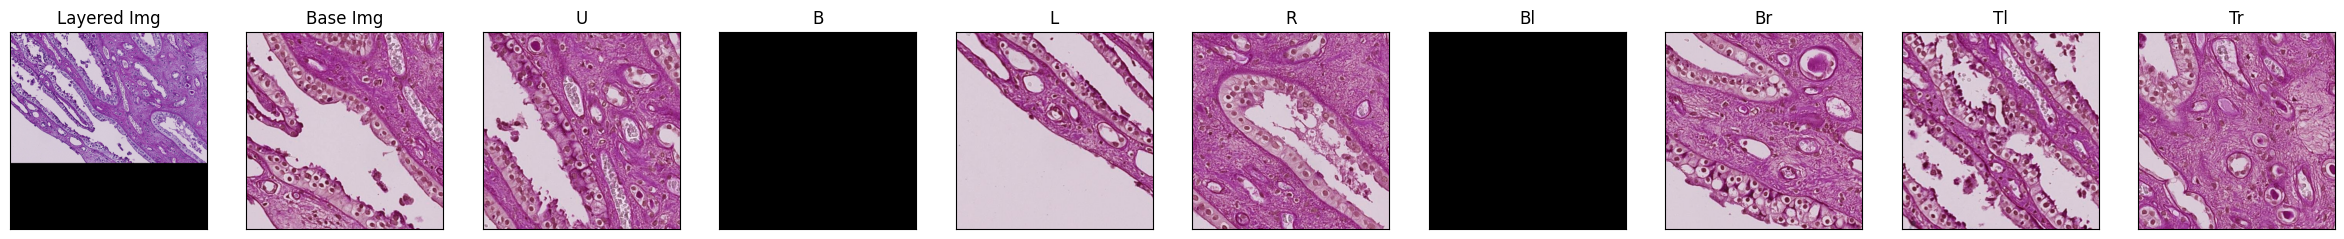

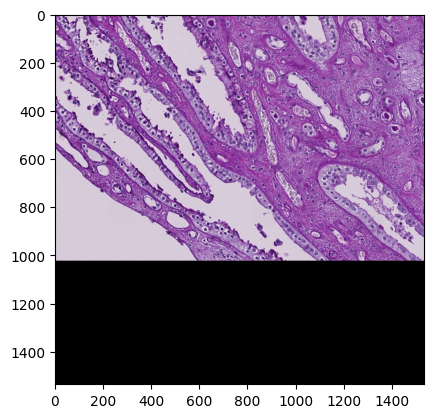

In [18]:
tgt_img_id = '733296a59c9b'
mode = 'validation'
fold = 0
num_layers = 1
base_img = load_img(input_imgs_dir, tgt_img_id)
layered_img = load_img(f'../dataset1_files/all_dataset1_{mode}_imgs_context_fold_{fold}', f'{tgt_img_id}_layered_{num_layers}')
tgt_img_dict = {'layered_img': layered_img, 'base_img': base_img}
tgt_adjacent_tile_dict = adjacent_tile_dict[tgt_img_id]
for direction in tgt_adjacent_tile_dict:
  cur_img_id = tgt_adjacent_tile_dict[direction]
  if cur_img_id is None:
    cur_img = np.zeros((512, 512, 3), dtype="uint8")
  else:
    cur_img = load_img(input_imgs_dir, cur_img_id)
  tgt_img_dict[direction] = cur_img
visualize(**tgt_img_dict)
plt.show()
plt.imshow(layered_img)
plt.show()

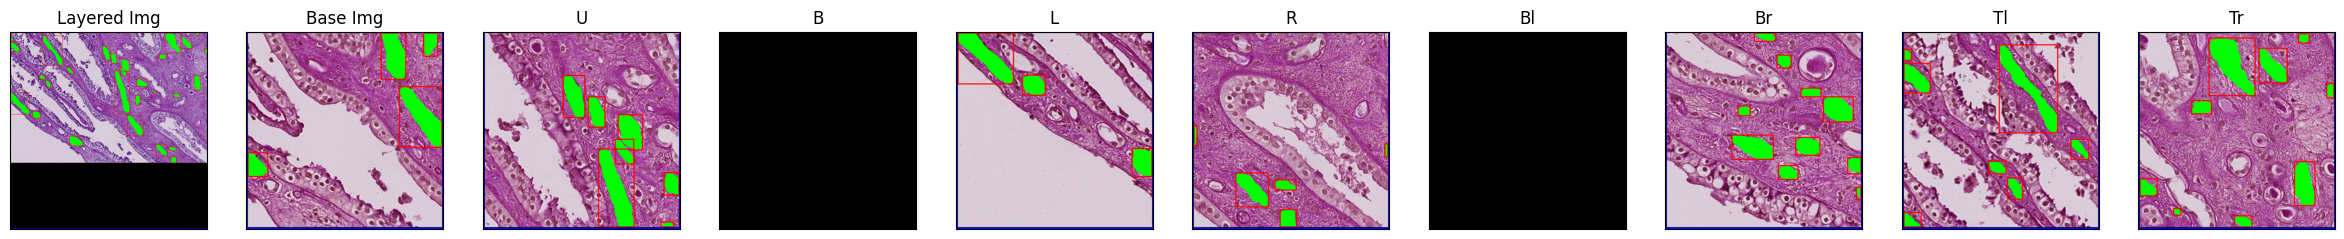

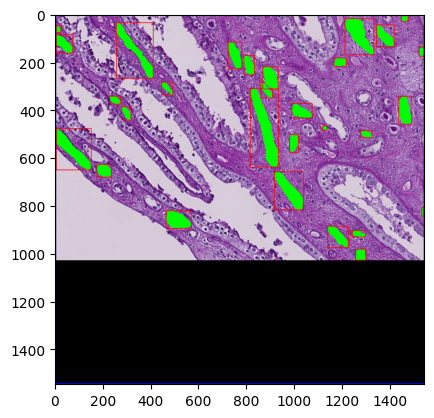

In [22]:
tgt_img_id = '733296a59c9b'
mode = 'validation'
fold = 0
num_layers = 1
base_img = get_annotated_img(input_imgs_dir, input_annots_dir, tgt_img_id)
layered_img = get_annotated_img(f'../dataset1_files/all_dataset1_{mode}_imgs_context_fold_{fold}' if mode != 'validation_custom' else f'../dataset1_files/all_dataset1_validation_imgs_context_fold_{fold}', f'../dataset1_files/all_dataset1_{mode}_annotations_context_fold_{fold}', f'{tgt_img_id}_layered_{num_layers}')
tgt_img_dict = {'layered_img': layered_img, 'base_img': base_img}
tgt_adjacent_tile_dict = adjacent_tile_dict[tgt_img_id]
for direction in tgt_adjacent_tile_dict:
  cur_img_id = tgt_adjacent_tile_dict[direction]
  if cur_img_id is None:
    cur_img = np.zeros((512, 512, 3), dtype="uint8")
  else:
    cur_img = get_annotated_img(input_imgs_dir, input_annots_dir, cur_img_id)
  tgt_img_dict[direction] = cur_img
visualize(**tgt_img_dict)
plt.show()
plt.imshow(layered_img)
plt.show()

In [ ]:
tgt_img_id = 'bb488d9b931e'
num_layers = 1
base_img = get_annotated_img(input_imgs_dir, input_annots_dir, tgt_img_id)
layered_img = get_annotated_img(output_imgs_dir, output_annots_dir, f'{tgt_img_id}_layered_{num_layers}')
tgt_img_dict = {'layered_img': layered_img, 'base_img': base_img}
tgt_adjacent_tile_dict = adjacent_tile_dict[tgt_img_id]
for direction in tgt_adjacent_tile_dict:
  cur_img_id = tgt_adjacent_tile_dict[direction]
  if cur_img_id is None:
    cur_img = np.zeros((512, 512, 3), dtype="uint8")
  else:
    cur_img = get_annotated_img(input_imgs_dir, input_annots_dir, cur_img_id)
  tgt_img_dict[direction] = cur_img
visualize(**tgt_img_dict)
plt.show()
plt.imshow(layered_img)
plt.show()

In [ ]:
print(list(adjacent_tile_dict.keys())[200:220])
print(list(adjacent_tile_dict.keys()).index('cb96f7b681f8'))

In [ ]:
import time
shifting_thresholds = [0.15,0.30,0.45,0.60,0.75,0.90]
print(f'Saving merged imgs and annots for {len(adjacent_tile_dict)} images...')
start_time = time.time()
for idx, img_id in enumerate(list(adjacent_tile_dict.keys())):
  save_merged_imgs(input_imgs_dir, output_imgs_dir, img_id, adjacent_tile_dict[img_id], shifting_thresholds)
  save_merged_annotations(output_annots_dir, img_id, adjacent_tile_dict[img_id], shifting_thresholds, tgt_tile_dicts)
  if (idx+1) % 50 == 0:
    print(f'Took {float(time.time()-start_time)} seconds to finish saving data for {idx+1} images')

In [ ]:
base_img_id = 'e7473674d813'
shifting_thresholds = [0.15,0.30,0.45,0.60,0.75,0.90]
save_merged_img_id_with_annot(output_imgs_dir, cleaned_output_annots_dir, vis_output_imgs_dir, base_img_id, adjacent_tile_dict[base_img_id], shifting_thresholds)

In [ ]:
base_img = load_img(vis_output_imgs_dir, f'{base_img_id}_full_annotated')
plt.imshow(base_img)
plt.show()
img = load_img(vis_output_imgs_dir, f'{base_img_id}_R_0.6_full_annotated')
# img_polygon_merged = load_img(vis_output_imgs_dir, f'{base_img_id}_BR_0.6_full_annotated_polygon_merged')
plt.imshow(img)
plt.show()
# plt.imshow(img_polygon_merged)
# plt.show()

In [ ]:
## Find polygons with less than 3 pairs of coordinates and remove them from the annotations
annot_files = os.listdir(output_annots_dir)
cleaned_output_annots_dir = f'{base_path}/dataset1_files/all_dataset1_annotations_merged_cleaned'
if not os.path.exists(cleaned_output_annots_dir):
    os.mkdir(cleaned_output_annots_dir)
for annot_file in annot_files:
  with open(f'{output_annots_dir}/{annot_file}', 'rb') as f:
    annots = pickle.load(f)
  cleaned_annots = [annot for annot in annots if len(annot['segmentation'][0]) >= 6]
  with open(f'{cleaned_output_annots_dir}/{annot_file}', 'wb') as f:
    pickle.dump(cleaned_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## Find polygons with less than 3 pairs of coordinates and remove them from the annotations
cleaned_output_annots_dir = f'{base_path}/dataset1_files/all_dataset1_annotations_merged_cleaned'
annot_files = os.listdir(cleaned_output_annots_dir)
for annot_file in annot_files:
    with open(f'{cleaned_output_annots_dir}/{annot_file}', 'rb') as f:
        annots = pickle.load(f)
    img_id = annot_file.split('.pkl')[0]
    for annot in annots:
        segmentation = annot['segmentation'][0]
        new_segmentation = [[pt[0], pt[1]] for pt in zip(segmentation[::2], segmentation[1::2])]
        if len(new_segmentation) < 3:
            print(f'Segmentation error for img is {img_id}')

In [ ]:
data

In [ ]:
base_img_id = '0033bbc76b6b'
img_dir = f'{base_path}/dataset1_files/all_dataset1_imgs'
shifting_threshold = 0.15
img_id_1 = base_img_id
img_1 = cv2.imread(f'{img_dir}/{img_id_1}.png')
print(img_1.shape)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
vis_dict = {'base_image': img_1}
for k in adjacent_tile_dict[base_img_id]:
  img_id_2 = adjacent_tile_dict[base_img_id][k]
  if img_id_2 is not None:
    img_2 = cv2.imread(f'{img_dir}/{img_id_2}.png')
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
    vis_dict[f'shift_image_{k}_orig'] = img_2
    if k in ['R', 'B', 'L']:
      shifted_image = single_shift_img(img_1, img_2, shifting_threshold, k)
      print(shifted_image.shape, k)
      vis_dict[f'shift_image_{k}_shifted'] = shifted_image
    else:
      if k == 'BL' and adjacent_tile_dict[base_img_id]['B'] is not None and adjacent_tile_dict[base_img_id]['L'] is not None:
        img_2 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['L']}.png")
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        img_3 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['B']}.png")
        img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)
        img_4 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id][k]}.png")
        img_4 = cv2.cvtColor(img_4, cv2.COLOR_BGR2RGB)
        shifted_image = double_shift_img(img_1, img_2, img_3, img_4, shifting_threshold, k)
        print(shifted_image.shape)
        vis_dict[f'shift_image_{k}_shifted'] = shifted_image
      elif k == 'BR' and adjacent_tile_dict[base_img_id]['B'] is not None and adjacent_tile_dict[base_img_id]['R'] is not None:
        img_2 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['R']}.png")
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        img_3 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['B']}.png")
        img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)
        img_4 = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id][k]}.png")
        img_4 = cv2.cvtColor(img_4, cv2.COLOR_BGR2RGB)
        shifted_image = double_shift_img(img_1, img_2, img_3, img_4, shifting_threshold, k)
        print(shifted_image.shape)
        vis_dict[f'shift_image_{k}_shifted'] = shifted_image
visualize(**vis_dict)

In [ ]:
base_img_id = '0033bbc76b6b'
img_dir = f'{base_path}/dataset1_files/all_dataset1_imgs'
shifting_threshold = 0.25
img_id_1 = base_img_id
img_1 = cv2.imread(f'{img_dir}/{img_id_1}.png')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
bottom_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['B']}.png")
bottom_img = cv2.cvtColor(bottom_img, cv2.COLOR_BGR2RGB)
left_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['L']}.png")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
bottom_left_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['BL']}.png")
bottom_left_img = cv2.cvtColor(bottom_left_img, cv2.COLOR_BGR2RGB)
image_top = cv2.hconcat([left_img, img_1])
image_bottom = cv2.hconcat([bottom_left_img, bottom_img])
final_img = cv2.vconcat([image_top, image_bottom])
plt.imshow(final_img)
plt.show()
shifted_image = double_shift_img(img_1, left_img, bottom_img, bottom_left_img, shifting_threshold, 'BL')
plt.imshow(shifted_image)
plt.show()

In [ ]:
base_img_id = '0033bbc76b6b'
img_dir = f'{base_path}/dataset1_files/all_dataset1_imgs'
shifting_threshold = 0.5
img_id_1 = base_img_id
img_1 = cv2.imread(f'{img_dir}/{img_id_1}.png')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
bottom_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['B']}.png")
bottom_img = cv2.cvtColor(bottom_img, cv2.COLOR_BGR2RGB)
right_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['R']}.png")
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
bottom_right_img = cv2.imread(f"{img_dir}/{adjacent_tile_dict[base_img_id]['BR']}.png")
bottom_right_img = cv2.cvtColor(bottom_right_img, cv2.COLOR_BGR2RGB)
image_top = cv2.hconcat([img_1, right_img])
image_bottom = cv2.hconcat([bottom_img, bottom_right_img])
final_img = cv2.vconcat([image_top, image_bottom])
plt.imshow(final_img)
plt.show()
shifted_image = double_shift_img(img_1, right_img, bottom_img, bottom_right_img, shifting_threshold, 'BR')
plt.imshow(shifted_image)
plt.show()